In [5]:
%matplotlib inline
from bs4 import BeautifulSoup
import requests
import pandas as pd 
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
from urllib.parse import urlparse
import urllib.parse
from adjustText import adjust_text

# note, artist name has ' ' replaced w/ '-' and special characters removed
# ie "anderson .paak" -> anderson-paak, 'j. cole' -> j-cole

# i believe same w/ album name
# maybe make a function that takes artist name and album name and creates the string
# req = requests.get(url)

# page = req.text
# soup = BeautifulSoup(page, 'html.parser')

# print(soup.title)

# # interested in links w/ class

# li = [l for l in soup.findAll('a') if l.get('href')]

# class = "song_name work_in_progress song_link"

# song_links = soup.findAll("a", {"class" : "song_name work_in_progress song_link"})

def rapperDriver(artist, album, toPlot=True):
    artist, album = str(artist), str(album) # just in case
    song_links = getSongLinks(artist, album)
    df = uniqueLyrics(song_links)
    df['artist'] = artist # add artist label
    df['length'] = songLen(artist, album, len(song_links) + 1)
    df['trackNum'] = (df.index + 1)


    if toPlot:
        ax = sns.regplot(x = df.length, y = df.nLyrics, fit_reg = False, data = df)
        ax.set(xlabel='song length (seconds)', ylabel='num unique words', title = artist + '-' + album)
        texts = []
        for xt, yt, s in zip(df.length, df.nLyrics, df.Song): # plt.text(x_coord, y_coord, label to put on that coord)
            texts.append(plt.text(xt, yt, s))
        adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

        plt.show()

    return df

# to do - get song title in songLen function and merge based on that.. indices for songs dont match up at times
# between genius and wikipedia ie 'slaughter your daughter' is song 14 on genius, song 5 on wiki
# but at the same time.. one song has the 'liq' in the title on genius and 'lick' for wikipedia
def getSongLinks(artist, album):

    artist, album = str(artist), str(album)
    # need to find a way to get rid of most special characters from the string
    artist = artist.replace('.', '')
    artist = re.sub(' ','-', artist)

    album = album.replace('.', '')
    album = re.sub(' ','-', album)

    url = "http://genius.com/albums/" + str(artist) + '/' + str(album)

    req = requests.get(url)

    page = req.text
    soup = BeautifulSoup(page, 'html.parser')

    # ul has track titles in order
    song_ul = soup.find("ul", {"class" : "song_list primary_list has_track_order"})
    song_links = [l.get('href') for l in song_ul.findAll('a')[0:albumLen(soup)]]
    # song_links = soup.findAll("a", {"class" : "song_name work_in_progress song_link"})
    # some songs have a diff class... need to figure a way to scrape the lyrics links despite the diff classes
    # add_songs = soup.findAll("a", {"class:" "song_name published song_link"})
    # if len(add_songs) != 0:
    # 	song_links.append()
    # song_links = [l.get('href') for l in song_links[0:albumLen(soup)]]


    return song_links
# but first, be sure that you're only getting the track numbers.. that's located in span tag w/ class = 'track_number'

def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def albumLen(soup, counter=0):
    for link in soup.findAll("span", {"class": "track_number"}):
        if hasNumbers(link.text):
            counter += 1
    return counter

def cleanTitle(string):
    string = string.split('by\xa0')
    string = string[:-1]
    string = ''.join(string)
    string = string.replace('\n', '')
    return string
    # print(albumLen(soup))

# print(song_links[0:albumLen(soup)])


# for link in song_links[0:albumLen(soup)]:
# 	if 'lyrics' in link.get('href'):
# 		print(link.get('href'))


# # now that I have the links for each song, go through each url 

# song = song_links[0].get('href')

# req = requests.get(song).text

# soup = BeautifulSoup(req, 'html.parser')

# song_lyrics = soup.find('p').text

# song_lyrics = re.sub('\[.*\]', '', song_lyrics)
# song_lyrics = re.sub('[^a-zA-Z0-9 \n\.]', '', song_lyrics)
# song_lyrics = song_lyrics.lower()
# song_lyrics = re.sub('[\n]', ' ', song_lyrics)
# print(len(set(song_lyrics.split(' '))) - 1)

def uniqueLyrics(song_url):
    # accepts a song url[s] (list) from the getSongLinks function.
    # return dictionary that maps the song title to the # of unique lyrics in the song

    li_title = []
    li_lyrics = []

    for song in song_url:
        req = requests.get(song).text

        soup = BeautifulSoup(req, 'html.parser')


        # getting the song title
        x = soup.title.text.split(' ')
        title = ' '.join(x[2 : x.index("Lyrics")]) # this assumes x has formal [artist_name, -, song title..., Lyrics]
        li_title.append(title)

        allLyrics = [l.text for l in soup.findAll('p') if '\n' in l.text]
        song_lyrics = ''.join(allLyrics)
        # song_lyrics = soup.find('p').text # maybe do soup.findAll.text if '/n' in text
        # get rid of square brackets and anything between them ie [hook], [verse i], etc
        song_lyrics = re.sub('\[.*\]', '', song_lyrics) 
        # get rid of all special characters except spaces
        song_lyrics = re.sub('[^a-zA-Z0-9 \n\.]', '', song_lyrics)

        song_lyrics = song_lyrics.lower()
        # get rid of the 'new line' elts.. not removed from the previous re.sub for some reason..
        song_lyrics = re.sub('[\n]', ' ', song_lyrics)
        tot_lyrics = len(set(song_lyrics.split(' '))) - 1
        li_lyrics.append(tot_lyrics)
        # mydict[title] = len(set(song_lyrics.split(' '))) - 1
    # subtract 1 b/c there is a ' ' in the list due to replaceing '\n' w/ ' '

    df = pd.DataFrame({"Song": li_title, "nLyrics": li_lyrics})
    # df.columns = ["Song", "nLyrics"]
    return df

def songLen(artist, album, length):
    artist, album = artist.replace(' ', '+'), album.replace(' ', '+')

    url = 'https://www.google.com/search?q=' + artist + '+' + album + '+wiki'
    req = requests.get(url)

    soup = BeautifulSoup(req.text)

    # gotta do this hella weird thing to get the url. see - http://stackoverflow.com/questions/21934004/not-getting-proper-links-from-google-search-results-using-mechanize-and-beautifu
    for a in soup.select('.r a'):
        if 'en.wikipedia.org' in urllib.parse.parse_qs(urllib.parse.urlparse(a['href']).query)['q'][0]:
            url = urllib.parse.parse_qs(urllib.parse.urlparse(a['href']).query)['q'][0]
            break

    req = requests.get(url)
    soup = BeautifulSoup(req.text)

    tab = soup.find('table', {"class" : 'tracklist'}) 
    duration = []
    for row in tab.findAll('tr')[1:length]:
        # col = row.findAll('td')[1::2]
        col = row.findAll('td')[-1].text
        # title.append(col[0].text)
        m, s = col.split(":")
        # duration.append(col[1].text)
        duration.append(int(m)*60 + int(s))
    return duration


/home/jarvis/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


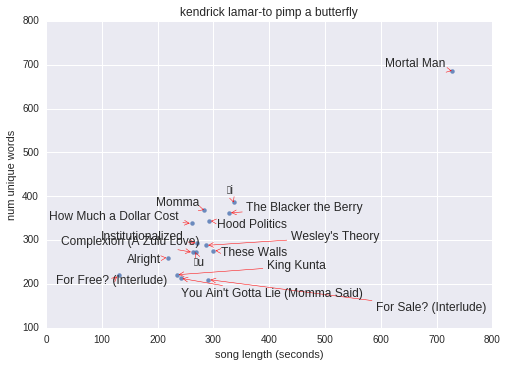

In [7]:
x = rapperDriver('kendrick lamar', 'to pimp a butterfly')

In [9]:
x

,Song,nLyrics,artist,length,trackNum
0,Wesley's Theory,288,kendrick lamar,287,1
1,For Free? (Interlude),220,kendrick lamar,130,2
2,King Kunta,221,kendrick lamar,234,3
3,Institutionalized,293,kendrick lamar,271,4
4,These Walls,276,kendrick lamar,300,5
5,​u,272,kendrick lamar,268,6
6,Alright,260,kendrick lamar,219,7
7,For Sale? (Interlude),210,kendrick lamar,291,8
8,Momma,369,kendrick lamar,283,9
9,Hood Politics,344,kendrick lamar,292,10
